To simulate a realistic quantum error correction scenario using the 3-qubit repetition code and generate a labeled dataset of syndrome measurements under noise. This dataset will be used for training a quantum neural network (QCNN) decoder.

Generating dataset: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


Saved dataset to qec_noisy_syndrome_dataset.csv
Sample 0 syndrome: [1, 0]


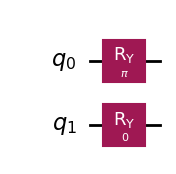

Sample 1 syndrome: [1, 0]


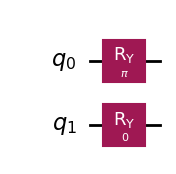

Sample 2 syndrome: [1, 1]


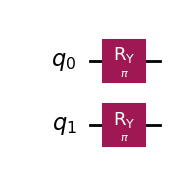

Sample 3 syndrome: [0, 1]


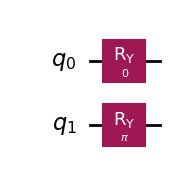

Sample 4 syndrome: [1, 1]


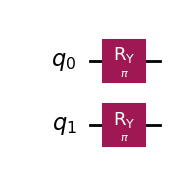

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
import numpy as np
import pandas as pd
import random
from tqdm import tqdm  # For progress bar

# Define Noise Model (depolarizing + readout noise)

def get_realistic_noise_model():
    noise_model = NoiseModel()

    # Depolarizing gate errors
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['x', 'h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

    # Bit-flip on measurement (2% readout error)
    meas_error = pauli_error([('X', 0.02), ('I', 0.98)])
    noise_model.add_all_qubit_quantum_error(meas_error, 'measure')

    return noise_model

#  Backend
noise_model = get_realistic_noise_model()
simulator = Aer.get_backend('aer_simulator')

#  Building 3-Qubit Repetition Code Circuit with Ancilla

def build_qec_syndrome_circuit(error_case=0, logical_bit=0):
    # Registers
    code = QuantumRegister(3, 'code')                # Physical qubits
    ancilla = QuantumRegister(2, 'ancilla')          # Syndrome ancillas
    syndrome_bits = ClassicalRegister(2, 'syndrome') # Measure syndromes only
    qc = QuantumCircuit(code, ancilla, syndrome_bits)

    # Encode logical |0⟩ or |1⟩
    if logical_bit == 1:
        qc.x(code)  # Apply X to all code qubits to get logical |1⟩

    # Encode entanglement
    qc.cx(code[0], code[1])
    qc.cx(code[0], code[2])

    # Inject error (bit-flip)
    if error_case == 1:
        qc.x(code[0])
    elif error_case == 2:
        qc.x(code[1])
    elif error_case == 3:
        qc.x(code[2])

    # Syndrome extraction (Z₀Z₁ → ancilla[0])
    qc.cx(code[0], ancilla[0])
    qc.cx(code[1], ancilla[0])
    qc.measure(ancilla[0], syndrome_bits[0])

    # Syndrome extraction (Z₁Z₂ → ancilla[1])
    qc.cx(code[1], ancilla[1])
    qc.cx(code[2], ancilla[1])
    qc.measure(ancilla[1], syndrome_bits[1])

    return qc

#  Dataset Generator (syndrome to error_class)

def generate_syndrome_dataset(n_samples=1000, logical_bit=0):
    data = []
    for _ in tqdm(range(n_samples), desc="Generating dataset"):
        error_case = random.randint(0, 3)  # 0 = no error, 1=X0, 2=X1, 3=X2
        qc = build_qec_syndrome_circuit(error_case=error_case, logical_bit=logical_bit)

        # Transpile the circuit for Aer simulator
        compiled = transpile(qc, simulator)

        # Run with noise model
        job = simulator.run(compiled, shots=1, memory=True, noise_model=noise_model)
        result = job.result()
        bits = result.get_memory()[0]  # e.g., '01'
        syndrome = [int(b) for b in bits]
        data.append(syndrome + [error_case])

    df = pd.DataFrame(data, columns=['syndrome_1', 'syndrome_2', 'error_class'])
    return df

#  Encoding Syndrome to QCNN-Compatible Input
def encode_syndrome_input(syndrome):
    qc = QuantumCircuit(2)
    qc.ry(syndrome[0] * np.pi, 0)
    qc.ry(syndrome[1] * np.pi, 1)
    return qc


#  Runing Everything and Saving

df = generate_syndrome_dataset(n_samples=1000)
df.to_csv("qec_noisy_syndrome_dataset.csv", index=False)
print("Saved dataset to qec_noisy_syndrome_dataset.csv")

# Test by encoding a few circuits
quantum_inputs = []
for i in range(5):
    syndrome = df.iloc[i][['syndrome_1', 'syndrome_2']].tolist()
    qc_input = encode_syndrome_input(syndrome)
    print(f"Sample {i} syndrome: {syndrome}")
    display(qc_input.draw('mpl'))
    quantum_inputs.append(qc_input)
